# Notebook Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 29 18:50:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# change directory
import os
os.chdir('/content/drive/MyDrive/HNN/pet')
!pwd

/content/drive/MyDrive/HNN/pet


In [3]:
# use tensorflow version 1.15.2
%tensorflow_version 1.x

# chack compatible keras version
import tensorflow as tf
print(tf.VERSION)
print(tf.keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.2.4-tf


In [5]:
# install correct keras version (2.2.4)
!pip install q keras==2.2.4

  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [6]:
# double check installations
import tensorflow as tf 
import keras 
print(tf.__version__)
print(keras.__version__)

1.15.2
2.2.4


Using TensorFlow backend.


In [2]:
import h5py
print(h5py.__version__)

2.10.0


In [11]:
# !pip install 'h5py==2.10.0' --force-reinstall

# Imports

In [12]:
!pwd

/content/drive/My Drive/HNN/pet


In [13]:
# add pet module to the system path
import sys
sys.path.append('/content/drive/My Drive/HNN')

In [14]:
import time
import pprint
import pickle
import os, sys
import pandas as pd
import random
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.utils import generic_utils
from keras.models import Model
import tensorflow.keras.backend as K

from pet.config import Config
from pet.parser import get_data
from pet.data_generators import get_anchor_gt
from pet.vgg import get_img_output_length, nn_base, rpn_layer, classifier_layer
from pet.losses import *
from pet.general import *
from pet.roi_helpers import rpn_to_roi, calc_iou

# Training configs

In [21]:
# 1. create parameters
this_model_name = 'model_lr_big'
# path that contains the annotation text file
train_path = '../data/pet/train_annotate.txt'

# number of ROI's to process at once
num_rois = 4
# Augmentation flag
horizontal_flips = True  # Augment with horizontal flips in training.
vertical_flips = True  # Augment with vertical flips in training.
rot_90 = False  # Augment with 90 degree rotations in training.

# location to save the trained model weights
output_weight_path = f'../trained_models/faster_rcnn/{this_model_name}'
# record data path - used to save losses, classification accuracy, and mean average precision
record_path = f'../trained_models/faster_rcnn/{this_model_name}/record.csv'
# base weight path
base_weight_path = f'../trained_models/faster_rcnn/{this_model_name}/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
# config file name
config_output_filename = f'../trained_models/faster_rcnn/{this_model_name}/model_vgg_config.pickle'

model_path = f'../trained_models/faster_rcnn/{this_model_name}/{this_model_name}.hdf5'

Configure parameters

In [22]:
# 2. create the config class instance
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois
C.anchor_box_scales = [32, 64, 128]

C.base_net_weights = base_weight_path

In [23]:
# 3. load the data
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )
print(train_imgs)

if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

Parsing annotation files
idx=271
Spend 0.03 mins to load the data
[{'filepath': '../data/pet/train/HN-HGJ-001-29.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 252, 'x2': 285, 'y1': 143, 'y2': 172}]}, {'filepath': '../data/pet/train/HN-HGJ-001-30.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 252, 'x2': 283, 'y1': 140, 'y2': 176}]}, {'filepath': '../data/pet/train/HN-HGJ-001-31.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 250, 'x2': 284, 'y1': 138, 'y2': 179}]}, {'filepath': '../data/pet/train/HN-HGJ-001-32.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 255, 'x2': 280, 'y1': 142, 'y2': 176}]}, {'filepath': '../data/pet/train/HN-HGJ-001-33.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 257, 'x2': 282, 'y1': 141, 'y2': 174}]}, {'filepath': '../data/pet/train/HN-HGJ-001-34.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 255, 'x2': 275, 'y1': 146, 'y2': 170}]

In [24]:
# Save the configuration
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C, config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Config has been written to ../trained_models/faster_rcnn/model_lr_big/model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [25]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

Original image: height=512 width=512
Resized image:  height=300 width=300 C.im_size=300
Feature map size: height=18 width=18 C.rpn_stride=16
(1, 300, 300, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 18, 18)
Shape of y_rpn_regr (1, 18, 18, 72)
{'filepath': '../data/pet/train/HN-HGJ-001-29.png', 'width': 512, 'height': 512, 'bboxes': [{'class': 'GTV', 'x1': 227, 'x2': 260, 'y1': 143, 'y2': 172}]}
Number of positive anchors for this image: 1
(array([ 5,  5, 10]), array([ 8,  8, 10]), array([0, 9, 7]))
(array([5, 5, 5, 5]), array([8, 8, 8, 8]), array([0, 1, 2, 3]))
y_rpn_cls for possible pos anchor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 1.          1.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

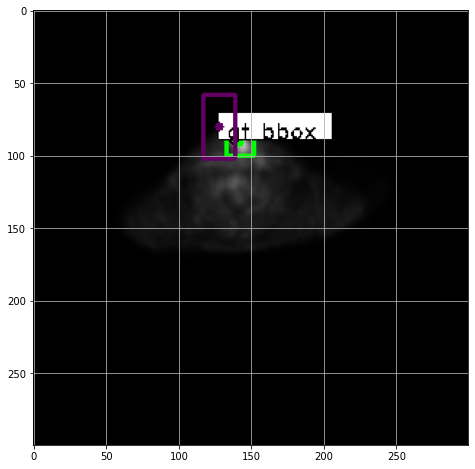

In [26]:
# 4. explore the data
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)
print('Number of positive anchors for this image: %d' % (debug_num_pos))
# draw a sample image
draw_sample(C, X, Y, image_data, debug_img, debug_num_pos)

# Build the model

In [27]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# print(model_all.summary())
C.model_path = model_path
print(C.model_path)
# Because the google colab can only run the session several hours one time (then you need to connect again),
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    # If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')

    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(
        columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls',
                 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)

    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches' % (len(record_df)))


'''LEARNING RATE '''
optimizer = Adam(lr=1e-3)
optimizer_classifier = Adam(lr=1e-3)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

print(model_classifier.summary())

../trained_models/faster_rcnn/model_lr_big/model_lr_big.hdf5
This is the first time of your training
loading weights from ../trained_models/faster_rcnn/model_lr_big/vgg16_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder             https://github.com/fchollet/keras/tree/master/keras/applications
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)     

# Training settings

In [28]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 1000
num_epochs = 300
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

print(len(record_df))

0


# Start Training

In [ ]:
# start training
start_time = time.time()
for epoch_num in range(num_epochs):
    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))

    r_epochs += 1

# insert While True: here
    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor)) / len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                # print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # get_updates(params=actor_model.trainable_weights, loss=loss)
            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            # R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois // 2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois // 2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples),
                                                            replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples),
                                                            replace=True).tolist()


                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos

            # print(sel_samples)
            # xxx = [X, X2[:, sel_samples, :]]
            # yyy = [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            # print(type(xxx[0]), xxx[0].shape)
            # print(type(xxx[1]), xxx[1].shape, xxx[1])
            # print(type(yyy[0]), yyy[0].shape)
            # print(type(yyy[1]), yyy[1].shape, yyy[1])

            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]],
                                                         [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            #
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]
            # #
            # # print(losses)

            iter_num += 1

            progbar.update(iter_num,
                           [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                            ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(
                        mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time() - start_time) / 60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss, curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes': round(mean_overlapping_bboxes, 3),
                           'class_acc': round(class_acc, 3),
                           'loss_rpn_cls': round(loss_rpn_cls, 3),
                           'loss_rpn_regr': round(loss_rpn_regr, 3),
                           'loss_class_cls': round(loss_class_cls, 3),
                           'loss_class_regr': round(loss_class_regr, 3),
                           'curr_loss': round(curr_loss, 3),
                           'elapsed_time': round(elapsed_time, 3),
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)
                print('*'*100)
                break

        except Exception as e:
            # print('except:  ')
            # exc_type, exc_obj, exc_tb = sys.exc_info()
            # fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            # print(exc_type, fname, exc_tb.tb_lineno)
            continue

Epoch 1/300
1000/1000 [==============================] - 353s 353ms/step - rpn_cls: 2.9825 - rpn_regr: 1.0639 - final_cls: 0.4922 - final_regr: 1.4977
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.4398413397972675
Classifier accuracy for bounding boxes from RPN: 0.97525
Loss RPN classifier: 3.06287113103332
Loss RPN regression: 0.5531749288560822
Loss Detector classifier: 0.33473337582294393
Loss Detector regression: 1.118666566967964
Total loss: 5.06944600268031
Elapsed time: 353.3099434375763
Total loss decreased from inf to 5.06944600268031, saving weights
****************************************************************************************************
Epoch 2/300
1000/1000 [==============================] - 380s 380ms/step - rpn_cls: 3.4354 - rpn_regr: 0.3729 - final_cls: 0.0597 - final_regr: 0.0075
Mean number of bounding boxes from RPN overlapping ground truth boxes: 0.4780322944048066
Classifier accuracy for bounding boxes from RPN: 0.99675
Loss RPN

# Plot training

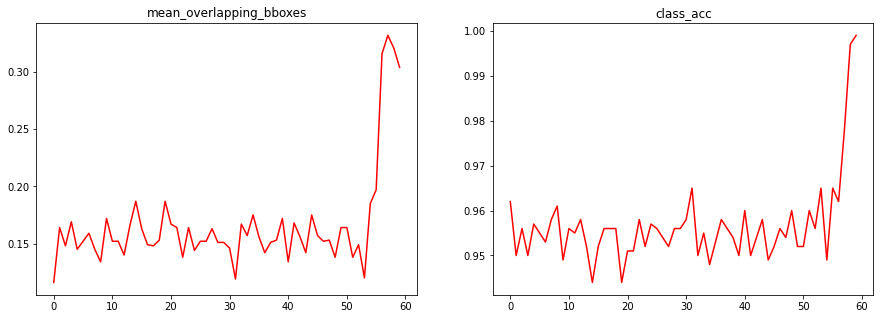

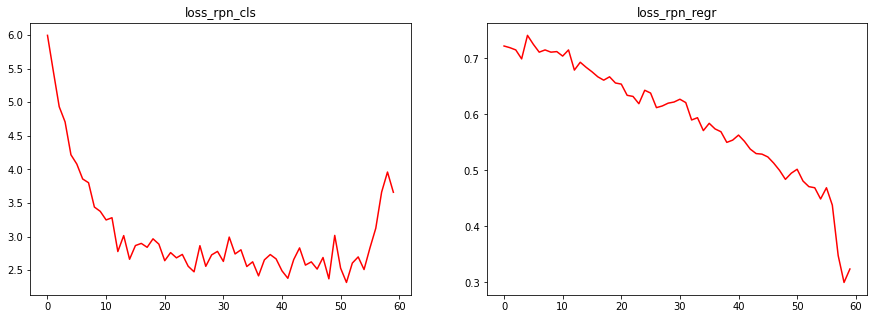

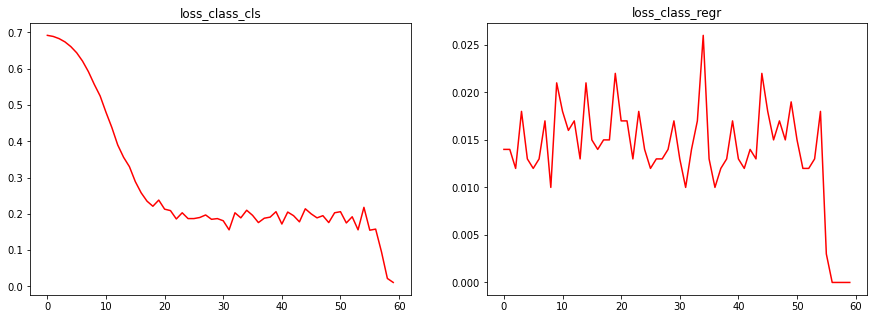

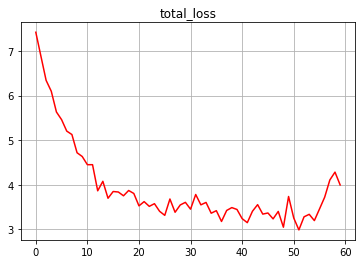

In [24]:
r_epochs = 60
record_df = pd.read_csv(C.record_path)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.grid()
plt.show()

In [ ]:
p